<a href="https://colab.research.google.com/github/andrewcxjin/aipi590-xai/blob/main/InterpretableML_Jin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Interpretable ML**
Dataset: https://www.kaggle.com/datasets/blastchar/telco-customer-churn/code

In [4]:
!pip install pygam --quiet

In [76]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from pygam import LogisticGAM, s, f, LinearGAM


In [64]:
# Load dataset and preview
import kagglehub

path = kagglehub.dataset_download("blastchar/telco-customer-churn")
df = pd.read_csv(path + "/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head(15)

Using Colab cache for faster access to the 'telco-customer-churn' dataset.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


###**Exploratory Data Analysis**

Perform an exploratory analysis of the dataset to understand the relationships between different features and the target variable (churn). Use appropriate visualizations and statistical methods to determine whether assumptions about linear, logistic, and GAM models are met.

In [65]:
# Explore Data Structures
print("Data Structure of dataframe")
for column in df.columns:
    print(f'Column Name: {column}, Data Type: {df[column].dtypes}')

Data Structure of dataframe
Column Name: customerID, Data Type: object
Column Name: gender, Data Type: object
Column Name: SeniorCitizen, Data Type: int64
Column Name: Partner, Data Type: object
Column Name: Dependents, Data Type: object
Column Name: tenure, Data Type: int64
Column Name: PhoneService, Data Type: object
Column Name: MultipleLines, Data Type: object
Column Name: InternetService, Data Type: object
Column Name: OnlineSecurity, Data Type: object
Column Name: OnlineBackup, Data Type: object
Column Name: DeviceProtection, Data Type: object
Column Name: TechSupport, Data Type: object
Column Name: StreamingTV, Data Type: object
Column Name: StreamingMovies, Data Type: object
Column Name: Contract, Data Type: object
Column Name: PaperlessBilling, Data Type: object
Column Name: PaymentMethod, Data Type: object
Column Name: MonthlyCharges, Data Type: float64
Column Name: TotalCharges, Data Type: object
Column Name: Churn, Data Type: object


In [66]:
# Check for missing values
print("Null Values in dataset")
null_counts = df.isnull().mean()
print(null_counts)

Null Values in dataset
customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64


In [67]:
# Visualize numerical and categorical features
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print('Numerical Features: ', num_cols)
print('Categorical Features: ', cat_cols)

Numerical Features:  ['SeniorCitizen', 'tenure', 'MonthlyCharges']
Categorical Features:  ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']


In [68]:
# Adjustments with numerical and categorical features
cat_cols.remove('customerID') # no need for customer ID in EDA

num_cols.remove('SeniorCitizen')
cat_cols.append('SeniorCitizen') # SeniorCitizen should be treated as categorical

cat_cols.remove('TotalCharges')
num_cols.append('TotalCharges') # TotalCharges should be treated as numerical

# Convert TotalCharges to numerical values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print('Null value count in TotalCharges: ', df['TotalCharges'].isnull().sum())

Null value count in TotalCharges:  11


In [69]:
null_rows = df[df['TotalCharges'].isnull()]
null_rows

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [70]:
# Rows with null values in TotalCharges have tenure=0
df['TotalCharges'].fillna(0, inplace=True)
print('Null value count in TotalCharges: ', df['TotalCharges'].isnull().sum())

Null value count in TotalCharges:  0


/tmp/ipython-input-111820193.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


In [71]:
print(df['TotalCharges'].dtypes)

float64


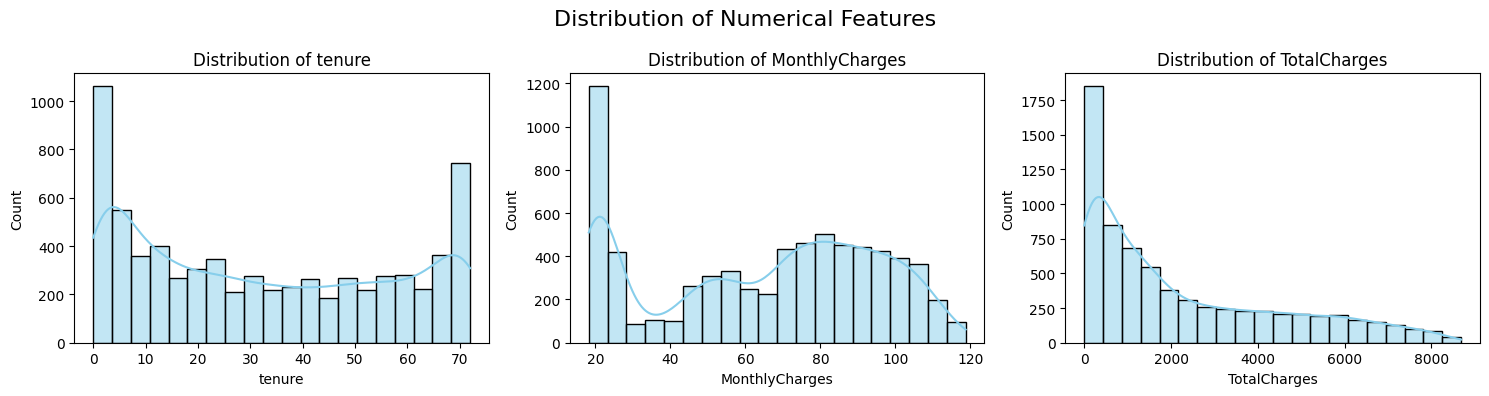

In [72]:
# Visualize distribution of numerical features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
  sns.histplot(df[col], kde=True, bins=20, ax=axes[i], color='skyblue', edgecolor='black')
  axes[i].set_title(f'Distribution of {col}')

plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

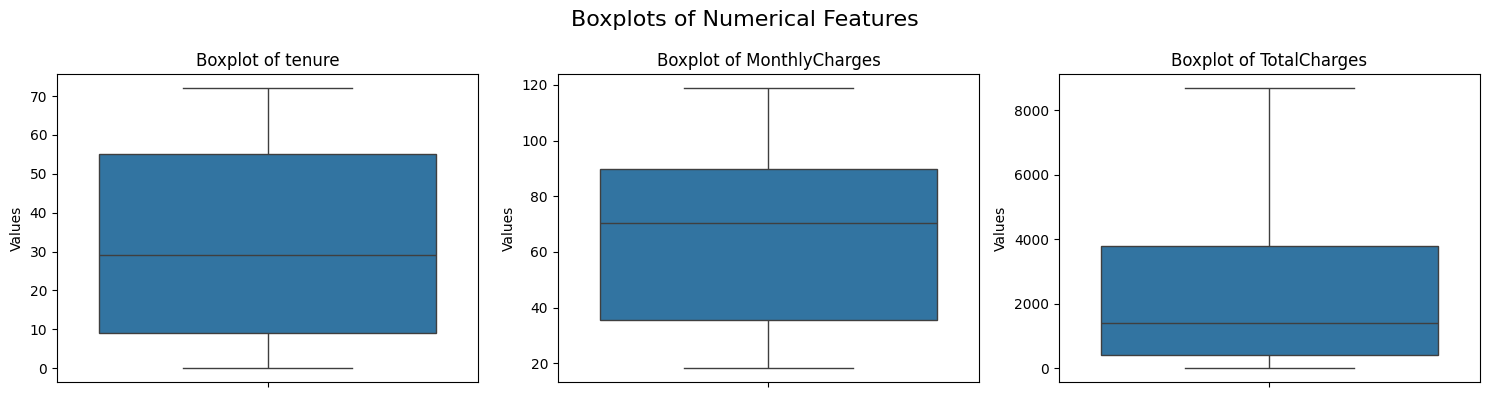

Outliers in tenure:  0
Outliers in MonthlyCharges:  0
Outliers in TotalCharges:  0


In [73]:
# Visualize boxplot of numerical features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
  sns.boxplot(data=df, y=col, ax=axes[i])
  axes[i].set_title(f'Boxplot of {col}')
  axes[i].set_ylabel('Values')

plt.suptitle('Boxplots of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

# Outlier detection
for col in num_cols:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
  print(f'Outliers in {col}: ', outliers.shape[0])

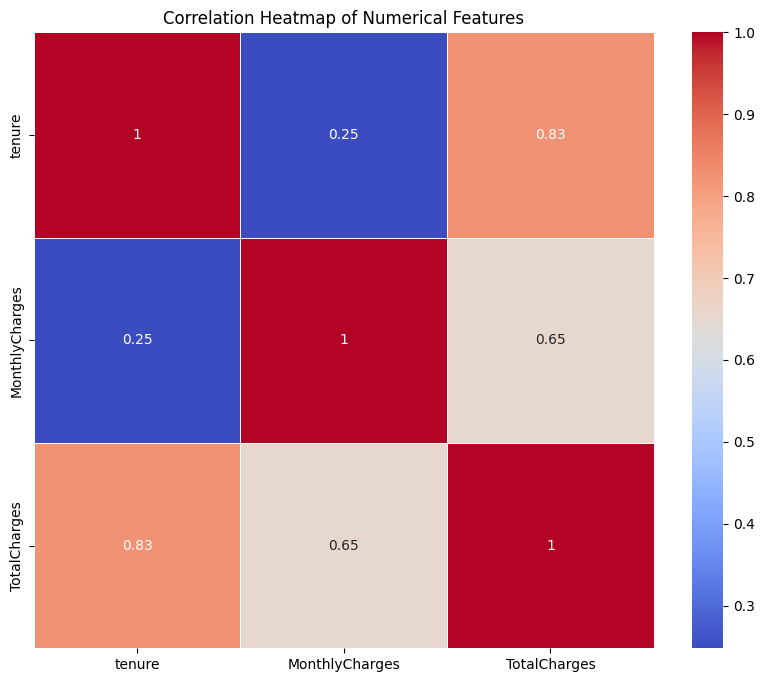

In [74]:
# Visualize heatmap of numerical features

corr_matrix = df[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

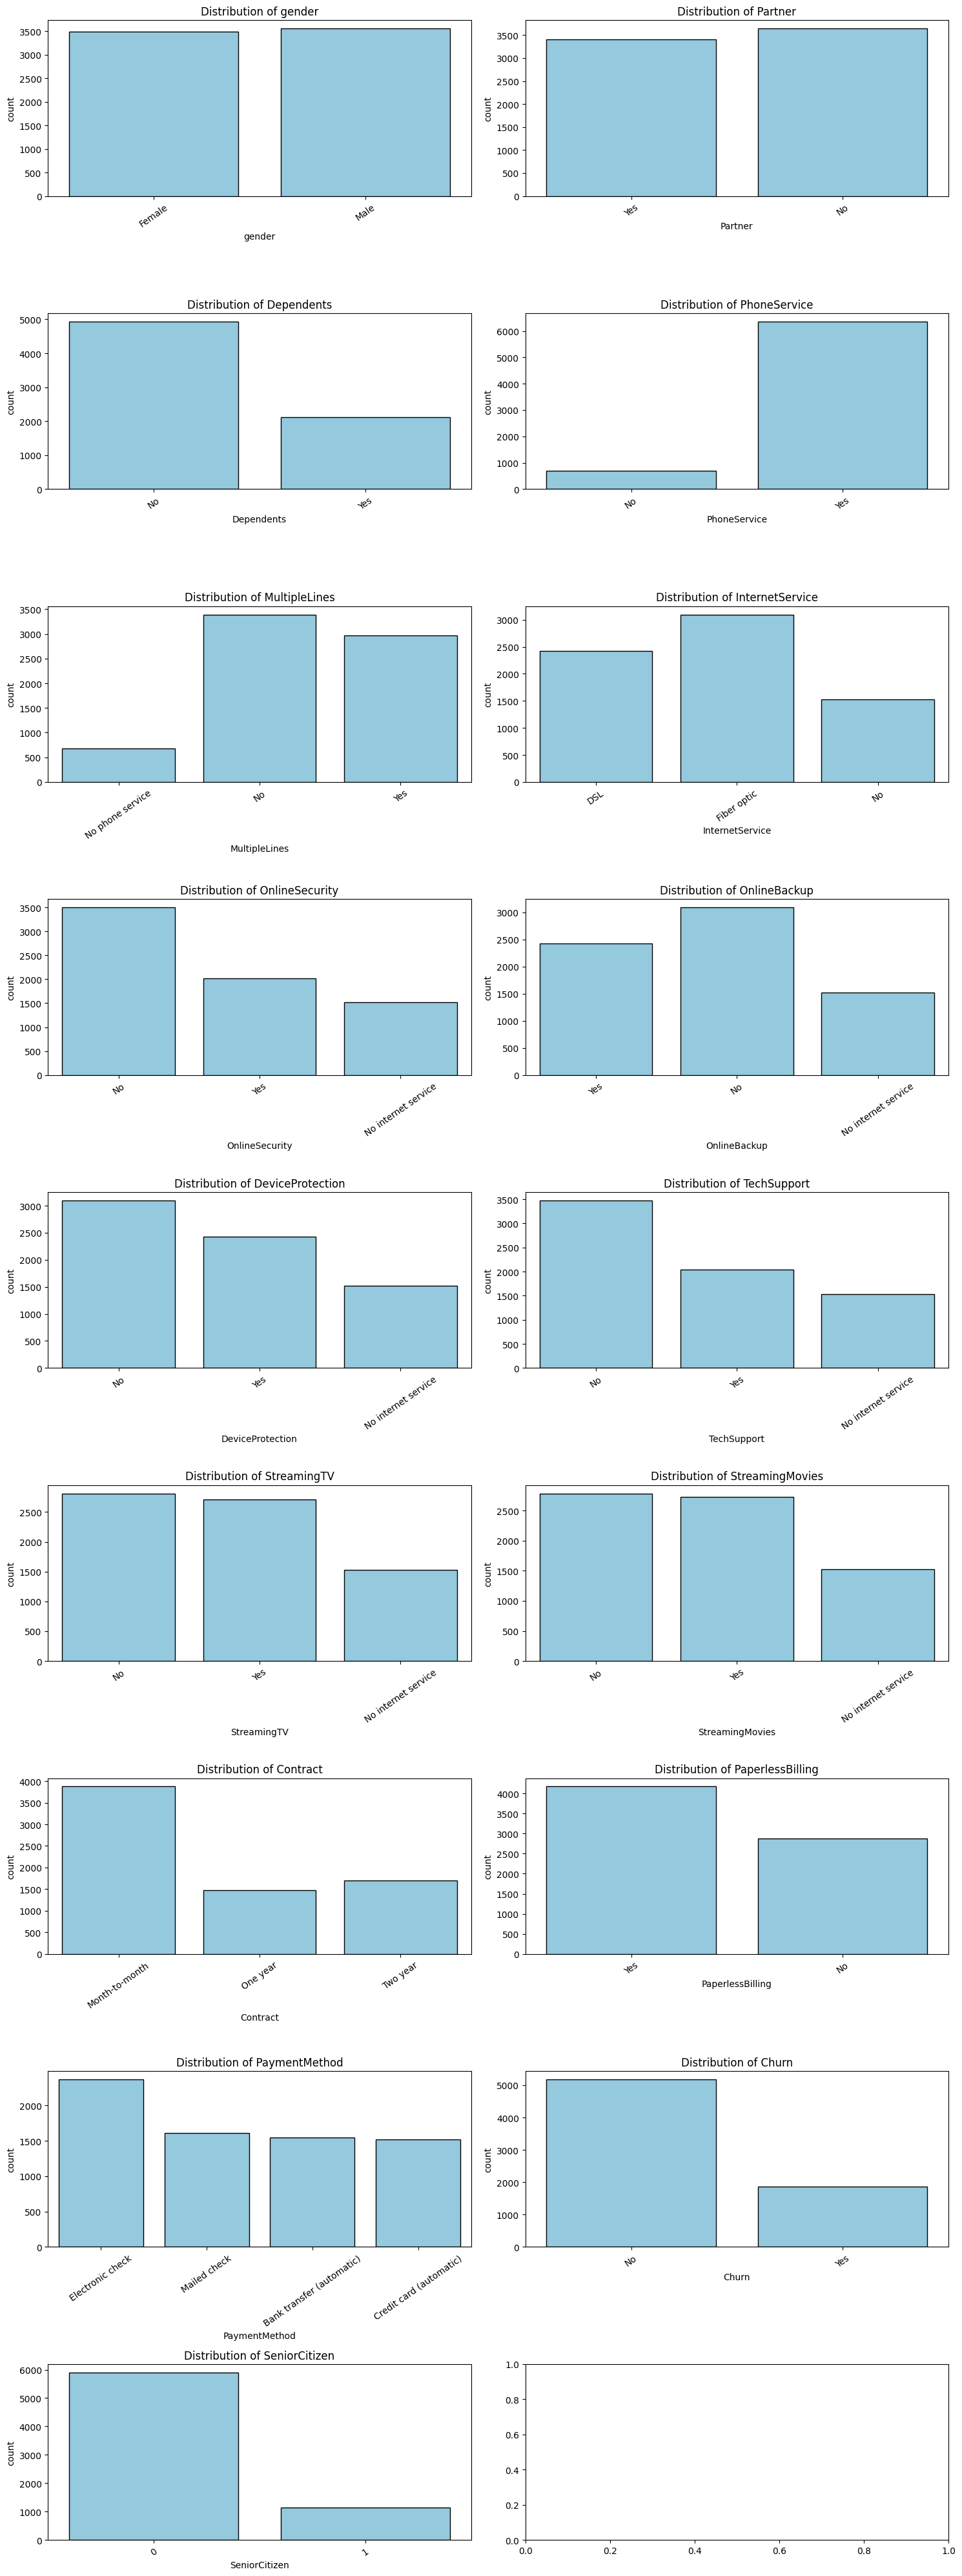

In [75]:
# Visualize distribution of categorical features

fig, axes = plt.subplots(len(cat_cols) // 2 + 1, 2, figsize=(15, 40))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
  sns.countplot(data=df, x=col, ax=axes[i], color='skyblue', edgecolor='black')
  axes[i].set_title(f'Distribution of {col}')
  axes[i].tick_params(axis='x', rotation=35)

plt.tight_layout()
plt.show()

In [77]:
# Change churn from yes/no to 1/0
# One-hot encoding for categorical variables
df.drop(columns=['customerID'], inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
cat_cols.remove('Churn')
cat_cols.remove('SeniorCitizen') # remove columns that already have numerical features
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df.drop(columns=['Churn'], axis=1)
y = df['Churn']
X = X.astype(float)

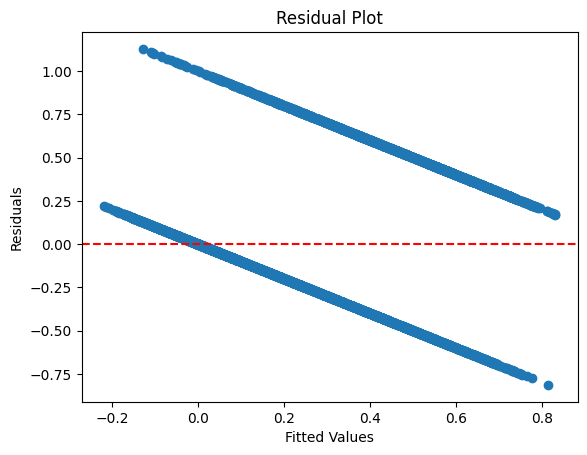

In [79]:
# Linearity
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [80]:
# Homoscedasticity
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']

for label, val in zip(labels, bp_test):
    print(f"{label}: {val:.4g}")

LM Statistic: 1377
LM-Test p-value: 4.813e-271
F-Statistic: 74.2
F-Test p-value: 1.017e-309


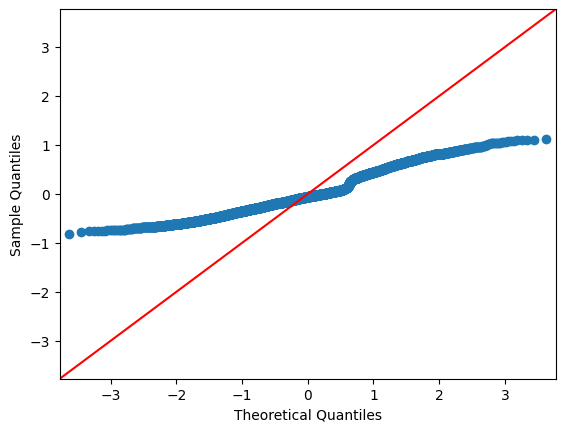

Shapiro-Wilk p-value: 1.864e-39


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7043.
  res = hypotest_fun_out(*samples, **kwds)


In [81]:
# Normality of Residuals
sm.qqplot(model.resid, line='45')
plt.show()

stat, p = shapiro(model.resid)
print("Shapiro-Wilk p-value:", f"{p:.4g}")

In [82]:
# Multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                  feature         VIF
0                                   const    0.000000
1                           SeniorCitizen    1.153365
2                                  tenure    7.527280
3                          MonthlyCharges  865.062147
4                            TotalCharges   10.793729
5                             gender_Male    1.002137
6                             Partner_Yes    1.462701
7                          Dependents_Yes    1.384430
8                        PhoneService_Yes         inf
9          MultipleLines_No phone service         inf
10                      MultipleLines_Yes    7.273906
11            InternetService_Fiber optic  148.263380
12                     InternetService_No         inf
13     OnlineSecurity_No internet service         inf
14                     OnlineSecurity_Yes    6.336249
15       OnlineBackup_No internet service         inf
16                       OnlineBackup_Yes    6.782866
17   DeviceProtection_No int

In [83]:
# Independence of Observation
dw_stat = durbin_watson(model.resid)
print("Durbin-Watson Value: ", dw_stat)

Durbin-Watson Value:  2.0053428831914015


In [24]:
# Influential Outliers
influence = OLSInfluence(model)

In [25]:
student_resid = influence.resid_studentized_external
outliers = np.where(np.abs(student_resid) > 3)[0]
print("Potential outliers:", outliers)

Potential outliers: [5441]


Linear regression model assumptions:
- Linearity
- Homoscedasticity
- Normality of residuals
- Independence of observations
- No multicollinearity

Logistic regression model assumptions:
- Independence of observations
- No multicollinearity
- No outliers

GAM regression model assumptions:
- Linearity
- Independence of observations
- No multicollinearity

The linearity assumption has not been met as the residuals vs. fitted values plot shows a pattern. If the features and target had a linear relationship, the points should've been scattered. Homoscedasticity also not been met as the p-value is less than 0.05 so we reject the null hypotheses that assumes homoscedasticity. The residuals are not normally distributed as shown by the Q-Q plot. The independence of observation assumption has been met. The Durbin-Watson test yielded a value of ~2 which indicates that there is no autocorrelation. There are a few predictors that have a VIF value greater than 10, which indicates that there is a multicollinearity issue so this assumption is also not met. We also see that there is one potential outlier using the studentized residual test, but other than that there seems to be no other extreme outliers. We can make adjustments to the variables or only select features that may seem important using methods such as Lasso regularization. For example, we can remove features that yielded a high VIF value from the multicollinearity test.

###**Linear Regression**
Treat the churn variable as a continuous variable (e.g., 0 for staying, 1 for churning) and build a linear regression model to predict churn. Interpret the coefficients and assess the model's performance.


In [27]:
# Split data and fit model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_scaled, y_train)

selected_features = X.columns[lasso.coef_ != 0]
X_train_selected = X_train_scaled[:, lasso.coef_ !=0]
X_test_selected = X_test_scaled[:, lasso.coef_ !=0]

model = LinearRegression()
model.fit(X_train_selected, y_train)

# Get predictions and performance statistics
y_pred = model.predict(X_test_selected)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("RMSE", rmse)
print("R2:", r2)


Mean Squared Error: 0.13393194633450745
RMSE 0.36596713832598066
R2: 0.3119221475904509


In [28]:
# Get coefficient values
coef_values = model.coef_
intercept_value = model.intercept_

coef_series = pd.Series(coef_values, index=selected_features)
print("Intercept:", intercept_value)
print("Coefficients for selected features:")
print(coef_series.sort_values(ascending=False))

Intercept: 0.2655307064252751
Coefficients for selected features:
InternetService_Fiber optic             0.084699
PaymentMethod_Electronic check          0.034663
StreamingMovies_Yes                     0.030679
MultipleLines_Yes                       0.024314
PaperlessBilling_Yes                    0.022352
StreamingTV_Yes                         0.021347
SeniorCitizen                           0.014136
gender_Male                            -0.004365
Dependents_Yes                         -0.009187
OnlineSecurity_No internet service     -0.009861
DeviceProtection_No internet service   -0.009861
StreamingTV_No internet service        -0.009861
TechSupport_No internet service        -0.009861
OnlineBackup_No internet service       -0.009861
InternetService_No                     -0.009861
PhoneService_Yes                       -0.010568
OnlineBackup_Yes                       -0.011022
TechSupport_Yes                        -0.022471
OnlineSecurity_Yes                     -0.026005
Con

Since our data didn't meet the assumptions for linear regressions, I attemped different methods to adjust the variables so that the assumptions could be met. For example, I attemped to remove the variables that yielded a VIF value greater than 10. However, this yielded poorer statistical results so in the end I decided to use Lasso regularization to pick out the important features. This yielded the highest MSE and R2 value of 0.13 and 0.31 respectively. If we look at the coefficients the model returned, all of them have a relatively weak impact on the churn. The interet service of Fiber Optic seems to have the highest impact on the churn probability rate while the total charges seems to have the highest impact in preventing churn. From all the coefficients, we can see that most of them are negative which indicates with each unit increase in these factors, it will decrease the churn probabilty rate by a factor of the coefficient. In the EDA we saw that there was a significantly higher rate for customers who didn't churn, which could explain why the majority of coefficients are negative. The returned statistics indicate that a linear regression may not be the best model to use to interpret patterns in churn.

###**Logistic Regression**
Treat churn as a binary variable and build a logistic regression model to predict the probability of churn. Interpret the coefficients.


In [29]:
# Split data and fit model
X = df.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Classification metrics
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1036
           1       0.69      0.58      0.63       373

    accuracy                           0.82      1409
   macro avg       0.78      0.75      0.76      1409
weighted avg       0.81      0.82      0.82      1409

Confusion Matrix:
[[939  97]
 [155 218]]
AUC Score: 0.8606131025702073


In [30]:
# Get coefficient values
coef_series = pd.Series(model.coef_[0], index=X.columns)
print("Logistic Regression Coefficients:")
print(coef_series.sort_values(ascending=False))

Logistic Regression Coefficients:
InternetService_Fiber optic              0.433004
StreamingMovies_Yes                      0.164349
PaperlessBilling_Yes                     0.162830
PaymentMethod_Electronic check           0.153683
MultipleLines_Yes                        0.141232
StreamingTV_Yes                          0.112456
MultipleLines_No phone service           0.077322
SeniorCitizen                            0.059315
Partner_Yes                              0.027973
PaymentMethod_Mailed check               0.004278
DeviceProtection_Yes                     0.002653
gender_Male                             -0.025841
PaymentMethod_Credit card (automatic)   -0.037434
StreamingMovies_No internet service     -0.046388
OnlineBackup_No internet service        -0.046388
StreamingTV_No internet service         -0.046388
InternetService_No                      -0.046388
OnlineSecurity_No internet service      -0.046388
TechSupport_No internet service         -0.046388
DeviceProtection

Overall we can see that the logistic regression has an AUC score of 0.86, meaning that approximately 86% of the predictions were correct. If we look at the precision and recall score of each churn outcome, we can see that the model performs worse for the positive class. This could be due to the data imbalance as there are significantly more negatives than positives. The confusion matrix shows that most of the predictions are true with a few false predictions. We can also see the different coefficients and how a change in one of them could lead to a log increase or decrease in the churn probability. Similar to the results from the coefficients of the linear regression model, we also see that the internet service of Fiber Optic has the highest positive coefficient. Here we only see the coefficients of binary variables so we don't observe the effect of the continuous variable. These continous variables, however, yielded high VIF values in the assumptions test so they would've been removed in the feature selection regardless.

###**Generalized Additive Model (GAM)**
Build a GAM to model the non-linear relationships between customer features and churn. Interpret the GAM model.

In [109]:
# Split data and fit model
X = df.drop(columns=['Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10))
gam.gridsearch(X_train_scaled, y_train)
gam.fit(X_train_scaled, y_train)

y_pred = gam.predict(X_test_scaled)

100% (11 of 11) |########################| Elapsed Time: 0:00:10 Time:  0:00:10


In [110]:
# Performance merics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("RMSE", rmse)
print("R2:", r2)

Mean Squared Error: 0.13317843679868238
RMSE 0.3649362092183816
R2: 0.31579331677278843


In [112]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     37.1719
Link Function:                     IdentityLink Log Likelihood:                                -13971.4301
Number of Samples:                         5634 AIC:                                             28019.204
                                                AICc:                                           28019.7385
                                                GCV:                                                0.1429
                                                Scale:                                              0.1412
                                                Pseudo R-Squared:                                    0.281
Feature Function                  Lam

/tmp/ipython-input-3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


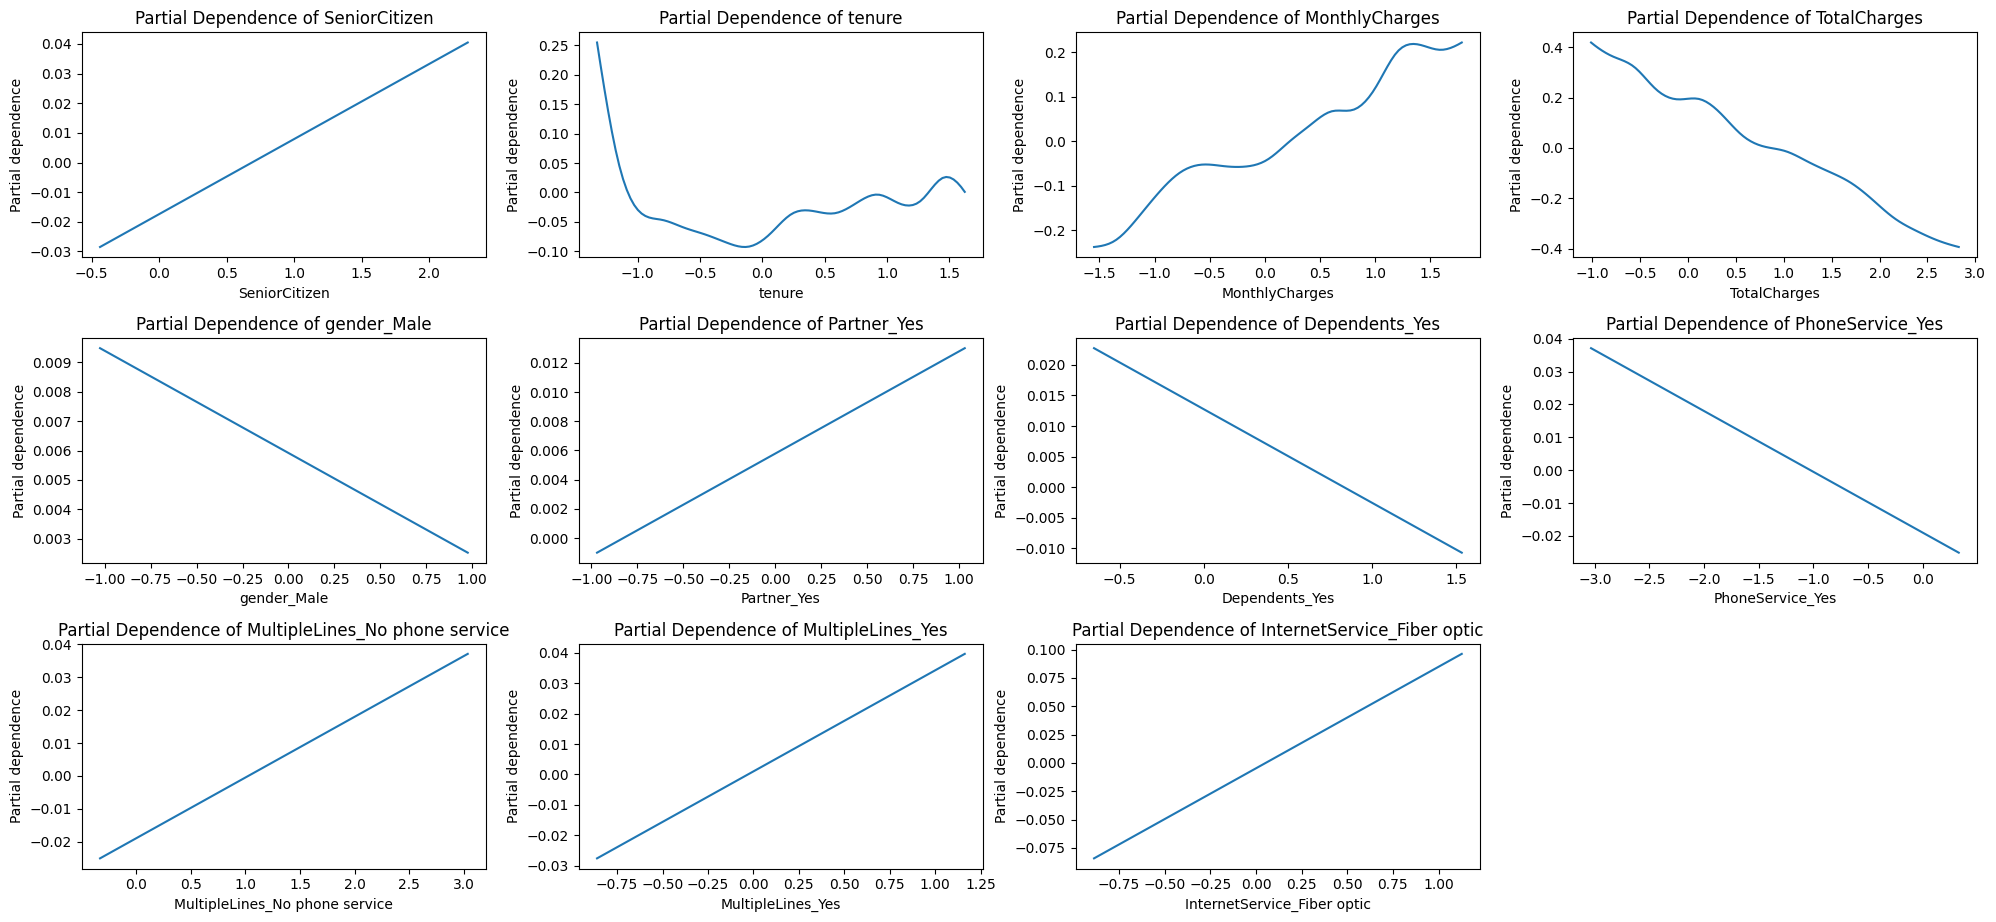

In [107]:
# Partial dependence
feature_names = X_train.columns
plt.figure(figsize=(20, 15))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.subplot(5, 4, i+1)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX))
    plt.title(f"Partial Dependence of {feature_names[term.feature]}")
    plt.xlabel(feature_names[term.feature])
    plt.ylabel('Partial dependence')
plt.tight_layout()
plt.show()

The statistics of the Linear GAM model seems to yield similar results to the Linear Regression model. I also attempeted to use a Logistic GAM model but the confusion matrix showed that it was predict no positives whatsoever. After playing around with different parameters and number of features, I chose to move forward with a Linear GAM model with 10 terms. The R2 of 0.32 shows that it has a low performance of making correct predictions. If we look at the partial dependences, we can see that most of the features have a relatively linear relationship except tenure. This feature has a non-linear relationship which means there might be a "sweet spot" of a tenure that leads to no churn or vice versa.

###**Model Comparison**
Compare the performance and interpretability of the different models you built. Discuss the strengths and weaknesses of each approach and provide recommendations for which model(s) the telecommunications company should use to address their customer churn problem.

The telecommunications company should use the Logistic Regression model to address their customer churn problem. The advantages of the Linear Regression model is that it's fast to compute and has coefficients that are easy to interpret. However, based on our model training and results, it yielded poor results with an R2 value of 0.31. The original dataset also didn't meet a lot of assumptions of linear regression, so processing the dataset also takes more effort. I also used one-hot encoding to transform categorical variables into binary values. Linear regression also doesn't work best with binary variables, especially when the target variable is also binary. This is when the Logistic Regression model comes handy. It's designed to handle binary outcomes and from our results we can see that approximately 86% of its predictions were correct. The classification metrics are also easy to interpret and differentiates the model's performance on the positive and negative class. From this, we were able to see that there is data imbalance, so a improvement we could make is splitting the data with a different method such as stratified. A weakness with both the Linear Regression and Logistic Regression model is that it has limited flexibility and can be impacted by non-linear relationships. To address this limitation, we can use a GAM model. As discussed earlier, both a Linear and Logistic GAM were implemented. The Linear GAM was chosen in the end as the Logistic GAM yielded poorer performance results. Another advantage of GAM models is that we can plot the effect of each feature and visualize it instead of solely looking at coefficients. A weakness with GAM models is that it requires more computation and can be more complex. The interpretation is also more visual which may not seem ideal to those who prefer numerical results. Given all these considerations, I would recommend the telecommuncation company to use a Logistic Regression model to address their customer churn company. With my experimentation I was having unsuccessful outcomes from a Logistic GAM model, but this could be another consideration if we could get it to work.